## Training to advection terms

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

import tree_math

In [2]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(mytowers)
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

<module 'jax_cfd.ml.diego_towers' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_towers.py'>

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [4]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape)
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 256, 64, 2)


In [6]:
def convect(v):  # pylint: disable=function-redefined
      return tuple(
          advection.advect_van_leer(u, v, dt) for u in v)
    
convection = cfd.equations._wrap_term_as_vector(convect, name='convection')

In [7]:
dim = 5
u = np.arange(dim**2).reshape(dim,dim)
v = np.arange(dim**2).reshape(dim,dim)*0.1

velField = jnp.dstack([u,v])
np.shape(velField)

(5, 5, 2)

In [8]:
def reshapeForAdvection(v):
    mygrid = (grids.GridVariable(array = grids.GridArray(data = v[:,:,0], 
                                            offset = (1.0, 0.5), 
                                            grid=grids.Grid(
                                                shape=(256, 64),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   ),
             grids.GridVariable(array = grids.GridArray(data = v[:,:,1], 
                                            offset = (0.5, 1.0),
                                            grid=grids.Grid(
                                                shape=(256, 64),  
                                                domain=((0.0, 8.0), (0.0, 2.0)) ) ),
#                        bc=cfd.boundaries.channel_flow_boundary_conditions(ndim=2)
                        bc = cfd.boundaries.periodic_boundary_conditions(2)
                   )
           )
    return tree_math.Vector(mygrid)

In [9]:
diego = reshapeForAdvection(velField)
diego

tree_math.Vector((GridVariable(array=GridArray(data=Array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(256, 64), step=(0.03125, 0.03125), domain=((0.0, 8.0), (0.0, 2.0)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0)))), GridVariable(array=GridArray(data=Array([[0. , 0.1, 0.2, 0.3, 0.4],
       [0.5, 0.6, 0.7, 0.8, 0.9],
       [1. , 1.1, 1.2, 1.3, 1.4],
       [1.5, 1.6, 1.7, 1.8, 1.9],
       [2. , 2.1, 2.2, 2.3, 2.4]], dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(256, 64), step=(0.03125, 0.03125), domain=((0.0, 8.0), (0.0, 2.0)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))))

In [23]:
flat = diego.tree_flatten()[0][0]
u = flat[0].array.data
v = flat[1].array.data

flat[0].

Array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.,  9.],
       [10., 11., 12., 13., 14.],
       [15., 16., 17., 18., 19.],
       [20., 21., 22., 23., 24.]], dtype=float32)

In [8]:
all_advected = []
for field in high_def:
    advected = convection(reshapeForAdvection(field))
    vel = 0
    uadv = advected.tree_flatten()[0][0][vel].data
    vel = 1
    vadv = advected.tree_flatten()[0][0][vel].data
    this_time = jnp.dstack([
            jnp.array(uadv),
            jnp.array(vadv)
        ])
    all_advected.append(this_time)

In [9]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = preprocessing.creatingDataset(high_def,preprocessing.sampling,factor)

print("\nCreate Y dataset: ")
padding = [1,1]
%time Y_dataset = preprocessing.creatingDataset(all_advected,preprocessing.sampling,factor)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]



# print("\nPadding all datasets: ")
# padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
# %time X_train = padXDataset(X_train,padding)
# %time Y_train = padYDatasetNew(Y_train,padding,conditions)

# %time X_test = padXDataset(X_test,padding)
# %time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 179 ms, sys: 10.9 ms, total: 190 ms
Wall time: 190 ms

Create Y dataset: 
CPU times: user 871 ms, sys: 11.9 ms, total: 883 ms
Wall time: 887 ms

Shapes of all datasets
(691, 64, 16, 2)
(691, 64, 16, 2)
(173, 64, 16, 2)
(173, 64, 16, 2)


In [4]:
def ConvNet(x):
    cnn = mytowers.CNN_Dropout(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 5,
    "hidden_layers" : 10,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [11]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [ ]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(40), #rng_key
                      input_channels=2,
                      epochs = 50,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((10,0.1),(20,0.01),(30,0.001)), #iterated over batches
                      batch_size=len(X_train)//2+1, # number or len(X_train)
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(691, 64, 16, 2)
(691, 64, 16, 2)
(173, 64, 16, 2)
(173, 64, 16, 2)



Start time: 12:21:32
Epoch 1/50
	mse : 0.033153		val mse : 0.063927	Estimated end time: 13:22:00


Epoch 2/50
	mse : 0.033116		val mse : 0.063899	Estimated end time: 13:41:36


Epoch 3/50
	mse : 0.033095		val mse : 0.063881	Estimated end time: 13:50:50


Epoch 4/50
	mse : 0.033080		val mse : 0.063869	Estimated end time: 13:56:16


Epoch 5/50
	mse : 0.033070		val mse : 0.063860	Estimated end time: 14:00:23


Epoch 6/50
	mse : 0.033061		val mse : 0.063853	Estimated end time: 14:02:53


Epoch 7/50
	mse : 0.033055		val mse : 0.063847	Estimated end time: 14:04:48


Epoch 8/50
	mse : 0.033049		val mse : 0.063841	Estimated end time: 14:06:24


Epoch 9/50
	mse : 0.033043		val mse : 0.063837	Estimated end time: 14:07:36


Epoch 10/50
	mse : 0.033039		val mse : 0.063833	Estimated end time: 14:08:38


Epoch 11/50
	mse : 0.033037		val mse : 0.063832	Estimated end time: 14:09:27


Epoch 12/50
	mse : 0.0330

In [ ]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [ ]:
description = "left for lunch, please save me"

In [ ]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [2]:
save_path = "./../models/final_models/advection_1.pickle"

In [ ]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

## Loading model

In [5]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [6]:
loaded.description

'left for lunch, please save me'

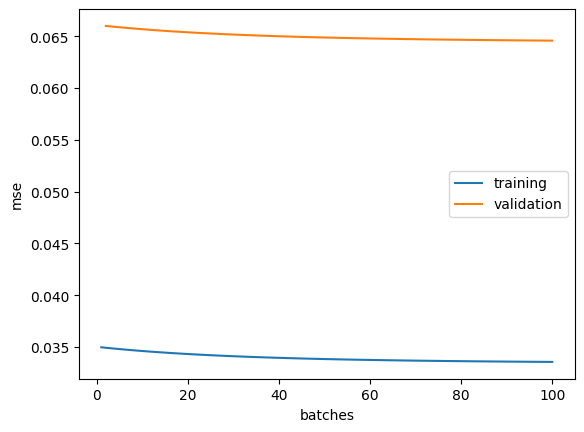

In [7]:
batches = np.arange(len(loaded.losses))
val_step = len(loaded.losses)//len(loaded.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,loaded.losses, label="training")
plt.plot(batches_val,loaded.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()